# Data Loading

In [1]:
import pandas as pd
#import janitor
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# -*- coding: utf-8 -*-
'''
a=pd.read_csv('ks-projects-201612.csv',encoding = "ISO-8859-1")
#remove empty columns
a_drop=[i for i in a.columns if 'Unnamed' in i]
a.drop(a_drop,axis=1,inplace=True)
'''
df=pd.read_csv('ks-projects-201801.csv',encoding = "ISO-8859-1")
#b.drop(['usd_pledged_real', 'usd_goal_real'],axis=1,inplace=True)
#%%


In [3]:
print(df.columns)
df.rename(columns={'usd pledged':'usd_pledged'},inplace=True)

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')


### data analysis + cleaning

In [4]:
#look for NaN
df.isna().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd_pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

I suggest dropping the projects that do not have a name tag.

In [5]:
df = df.dropna(subset=['name'])
df.isna().sum()

ID                     0
name                   0
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd_pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

usd_pledged: conversion in US dollars of the pledged column (conversion done by kickstarter).
usd pledge real: conversion in US dollars of the pledged column (conversion from Fixer.io API).
usd goal real: conversion in US dollars of the goal column (conversion from Fixer.io API).

In 3797 cases Kickstarter did not convert the currency successfully to USD (usd_pledged)
Let us further investigate that issue.

In [6]:
#df where currency is USD, and USD_pledged differs from pledged even though the currency did not change
df[df['currency']=='USD'][['usd_pledged_real','usd_pledged','pledged','currency']][df['usd_pledged']!=df['pledged']].head(10)
#46581 entries seem to have a conversion error from USD to USD 
#so how many others are there? How do other currencies look? Is Fixer.io good?

C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,usd_pledged_real,usd_pledged,pledged,currency
1,2421.00,100.0,2421.00,USD
29,57577.31,10120.0,57577.31,USD
31,47266.00,11253.0,47266.00,USD
41,2100.00,83.0,2100.00,USD
43,856.00,324.0,856.00,USD
51,6.00,5.0,6.00,USD
71,141.00,100.0,141.00,USD
102,1055.00,0.0,1055.00,USD
103,156.00,1.0,156.00,USD
106,22.00,7.0,22.00,USD


In [7]:
#number of unique currencies
print(df.currency.unique())

['GBP' 'USD' 'CAD' 'AUD' 'NOK' 'EUR' 'MXN' 'SEK' 'NZD' 'CHF' 'DKK' 'HKD'
 'SGD' 'JPY']


In [8]:
#Google 28.02.2020
to_usd={'GBP':1.29, 'USD':1, 'CAD':0.74, 'AUD':0.65, 'NOK':0.11, 'EUR':1.1, 'MXN':0.05, 'SEK':0.10, 'NZD':0.63,
       'CHF':1.04, 'DKK':0.15, 'HKD':0.13, 'SGD':0.72, 'JPY':0.0092}

#function to compare what Kickstarter sais he currency is vs what it should be with current exchange rate within in margin X%
# inf values from deviding by 0 were marked with NaN and then replaced with the mean ignoring the NaNs
def within_Xp(df,X,to_usd=to_usd,col_base='pledged',col_comp='usd_pledged'):
    diff=df[col_base]*[to_usd[i] for i in df['currency']]/df[col_comp]
    diff.replace([np.inf, -np.inf], np.nan,inplace=True)
    diff.replace([np.nan], diff.mean(skipna=True),inplace=True)
    stats=[diff.mean(),diff.std(),len(diff[(diff>(1+X)) | (diff<(1-X))]),len(diff[(diff>(1+X)) | (diff<(1-X))])/len(df)]
    print(col_base,'vs',col_comp,'\nmean,std,,#out of dataset outside','1+-'+str(X),'%out of dataset outside','1+-'+str(X),'\n',stats)
    return diff[(diff>(1+X)) | (diff<(1-X))],stats

pledged vs usd_pledged 
mean,std,,#out of dataset outside 1+-0.3 %out of dataset outside 1+-0.3 
 [6.747186426888382, 429.6821928759382, 119393, 0.3153064646896796]


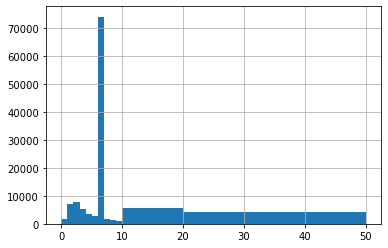

In [9]:
#Kickstarter conversion pledged to USD allowing a possible 30% change in currency since 2014
diff,stats=within_Xp(df,0.3,to_usd=to_usd,col_base='pledged',col_comp='usd_pledged')
diff.hist(bins=[0,1,2,3,4,5,6,7,8,9,10,20,50])

In [10]:
# the big spike is the inf entries changed to the mean
# 30% of the data is not within boundaries

pledged vs usd_pledged_real 
mean,std,,#out of dataset outside 1+-0.3 %out of dataset outside 1+-0.3 
 [0.9797469572100377, 0.052463496479505385, 622, 0.0016426475675875528]


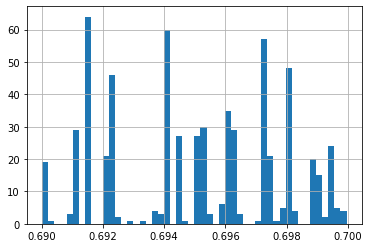

In [11]:
#Fixer.io conversion pledged to USD allowing a possible 30% change in currency since 2014
diff,stats=within_Xp(df,0.3,to_usd=to_usd,col_base='pledged',col_comp='usd_pledged_real')
diff.hist(bins=50)

In [12]:
# at 40% there is no more outliers, so I believe it is best to drop pledged_usd and go with pledged_usd_real

In [13]:
df.drop(columns='usd_pledged',inplace=True)

In [14]:
#check for duplicates
df.duplicated().any()

False

In [15]:
#set datetime
df['launched']=pd.to_datetime(df['launched'])
df['deadline']=pd.to_datetime(df['deadline'])

## Categorical Features

In [16]:
#the categorical features and the contribution of the top 15 features to the data
for i in df.columns:
    print('\n',i,df[i].dtype)
    if df[i].dtype=='object' and i!='name':
        #print('# of categories in',i,len(df[i].unique()),'\n',df[i].unique())
        p={e:(df[i]==e).sum()/len(df) for e in df[i].unique()}
        p_sorted={k: v for k, v in sorted(p.items(), key=lambda item: item[1],reverse=True)}
        print({x:p_sorted[x] for c,x in enumerate(p_sorted) if c<15 },'\n')


 ID int64

 name object

 category object
{'Product Design': 0.05892668034659335, 'Documentary': 0.04262168664516964, 'Music': 0.04153363070007949, 'Tabletop Games': 0.03744813908101527, 'Shorts': 0.03263375561524018, 'Video Games': 0.031239353821532416, 'Food': 0.03035200722553657, 'Film & Video': 0.026694343429541776, 'Fiction': 0.024214526603231947, 'Fashion': 0.022590365423060976, 'Nonfiction': 0.021967110075873417, 'Art': 0.021795450764148027, 'Apparel': 0.018924778889601937, 'Theater': 0.0186369194284009, 'Technology': 0.018301523542414374} 


 main_category object
{'Film & Video': 0.16791977964226198, 'Music': 0.13711089455628708, 'Publishing': 0.10530374454981685, 'Games': 0.09303934695515995, 'Technology': 0.08601187882437139, 'Design': 0.07940959760416419, 'Art': 0.07434696836450931, 'Food': 0.06497172903181507, 'Fashion': 0.06025505932809905, 'Theater': 0.028820277982448496, 'Comics': 0.028572032208568705, 'Photography': 0.02846639570904539, 'Crafts': 0.02326379810752211, '

In [17]:
state_p={i:(df.state==i).sum()/len(df) for i in df.state.unique()}
state_p_sorted={k: v for k, v in sorted(state_p.items(), key=lambda item: item[1],reverse=True)}

print(state_p_sorted)

{'failed': 0.5221506534937952, 'successful': 0.3537660732536306, 'canceled': 0.10241194537536609, 'undefined': 0.009406930282551226, 'live': 0.007391914054143988, 'suspended': 0.004872483540512918}


https://www.kaggle.com/kemical/kickstarter-projects/discussion/67067
This user hinted that there are successful project without backers
We will remove them

In [18]:
print('0 backers and succeeded:',((df.backers==0)&(df.state=='successful')).sum())
df[(df.backers==0)&(df.state=='successful')].country.unique()
df=df[~((df.backers==0)&(df.state=='successful'))]

0 backers and succeeded: 105


In [19]:
print('0 backers and money invested:',((df.backers==0)&(df.pledged>0)).sum())
df=df[~((df.backers==0)&(df.pledged>0))]
len(df[~((df.state=='successful')|(df.state=='failed'))])/len(df)

0 backers and money invested: 2977


0.11740398056313653

In [20]:
print('failed and goal reached:',((df.state=='failed')&(df.usd_goal_real<df.usd_pledged_real)).sum())
df=df[~((df.state=='failed')&(df.usd_goal_real<df.usd_pledged_real))]

failed and goal reached: 4


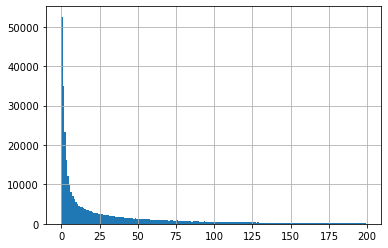

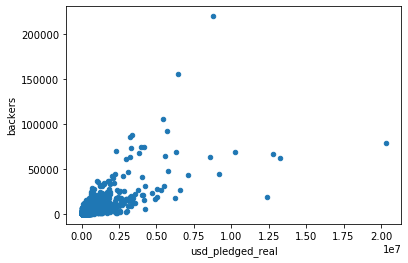

In [21]:
df.backers.hist(bins=range(200))
df[['usd_pledged_real','backers']].plot.scatter(x='usd_pledged_real',y='backers')

# PCA

In [22]:
#translating date 
for i in ['launched','deadline']:
    df[i+'_month']=pd.DatetimeIndex(df.launched).month
    df[i+'_week']=pd.DatetimeIndex(df.launched).week
    df[i+'_day']=pd.DatetimeIndex(df.launched).day
    df[i+'_weekday']=pd.DatetimeIndex(df.launched).weekday
df['timeframe']=(df.deadline-df.launched).astype('timedelta64[h]')/24


In [23]:
df_pca=pd.get_dummies(df.drop(columns=['name','ID','deadline','launched','goal','usd_pledged_real','pledged','backers']),columns=['category','launched_month', 'launched_week', 'launched_day',
       'launched_weekday', 'deadline_month', 'deadline_week', 'deadline_day', 'deadline_weekday' ,'main_category', 'currency','country'])
df_pca=df_pca[(df_pca['state']=='failed')|(df_pca['state']=='successful')]

In [24]:
#Useful for later classification
mappings={}
from sklearn.preprocessing import LabelEncoder

categorical=['category', 'main_category', 'currency','state','country']

def cat_to_int(df,cats,mappings):
    for i in cats:
        le = LabelEncoder()
        df[i+'_int']=le.fit_transform(df[i])+1
        le.fit(df[i])
        mappings[i] = dict(zip(le.classes_, le.transform(le.classes_)+1))
        df.drop(columns=[i],inplace=True)

    return df , mappings

In [25]:
mappings_pca={}

df_pca,mappings_pca=cat_to_int(df_pca,['state'],mappings_pca)

In [26]:
mappings_pca

{'state': {'failed': 1, 'successful': 2}}

In [27]:
from scipy.linalg import svd
df_pca_s=df_pca[df_pca['state_int']==2]
df_pca_f=df_pca[df_pca['state_int']==1]

attributeNames=list(df_pca.columns)

y=df_pca.state_int


N=len(df_pca)
X=df_pca.drop(columns='state_int').values
#Y = X - np.ones((N,1))*X.mean(axis=0)

from sklearn import preprocessing

x = X #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_pca=pd.DataFrame(x_scaled, columns=df_pca.drop(columns='state_int').columns)

#%%
# PCA by computing SVD of Y
U,S,V = svd(x_scaled,full_matrices=False)
Z = x_scaled @ V


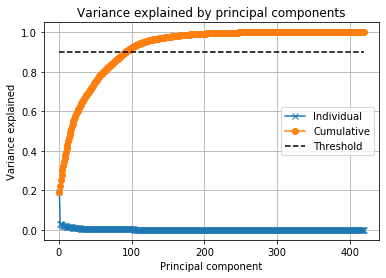

In [28]:
rho = (S*S) / (S*S).sum() 

threshold = 0.9

# Plot variance explained
plt.figure()
plt.plot(range(1,len(rho)+1),rho,'x-')
plt.plot(range(1,len(rho)+1),np.cumsum(rho),'o-')
plt.plot([1,len(rho)],[threshold, threshold],'k--')
plt.title('Variance explained by principal components');
plt.xlabel('Principal component');
plt.ylabel('Variance explained');
plt.legend(['Individual','Cumulative','Threshold'])
plt.grid()
plt.show()

C:\Users\steve\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


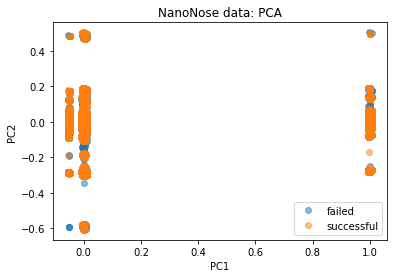

In [29]:
from matplotlib.pyplot import figure, plot, title, xlabel, ylabel, show, legend


i = 0
j = 1
classNames=[i for i in mappings_pca['state']]
C = len(classNames)

# Plot PCA of the data
f = figure()
title('NanoNose data: PCA')
#Z = array(Z)
for c in range(C):
    # select indices belonging to class c:
    class_mask = y==c+1
    plot(Z[class_mask,i], Z[class_mask,j], 'o', alpha=.5)
legend(classNames)
xlabel('PC{0}'.format(i+1))
ylabel('PC{0}'.format(j+1))

# Output result to screen
show()

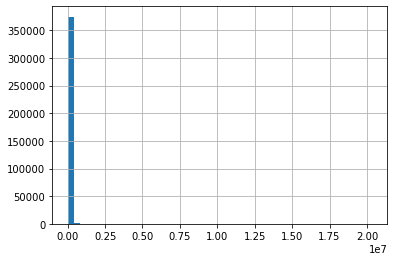

In [30]:
df[df.usd_pledged_real==df.usd_pledged_real.max()]
df.usd_pledged_real.hist(bins=50)

In [ ]:

Y1 = X - np.ones((N, 1))*X.mean(0)

# Subtract the mean from the data and divide by the attribute standard
# deviation to obtain a standardized dataset:
Y2 = X - np.ones((N, 1))*X.mean(0)
#Y2 = Y2*(1/np.std(Y2,0))
Y2=x_scaled

Ys = [Y1, Y2]
titles = ['Zero-mean', 'Zero-mean and unit variance']
threshold = 0.9
# Choose two PCs to plot (the projection)
i = 0
j = 1

# Make the plot
plt.figure(figsize=(10,15))
plt.subplots_adjust(hspace=.4)
plt.title('NanoNose: Effect of standardization')
nrows=3
ncols=2


for k in range(2):
    # Obtain the PCA solution by calculate the SVD of either Y1 or Y2
    U,S,Vh = svd(Ys[k],full_matrices=False)
    V=Vh.T # For the direction of V to fit the convention in the course we transpose
    # For visualization purposes, we flip the directionality of the
    # principal directions such that the directions match for Y1 and Y2.
    if k==1: V = -V; U = -U; 
    
    # Compute variance explained
    rho = (S*S) / (S*S).sum() 
    
    # Compute the projection onto the principal components
    Z = U*S;
    
    # Plot projection
    plt.subplot(nrows, ncols, 1+k)
    C = len(classNames)
    for c in range(C):
        plt.plot(Z[y==c,i], Z[y==c,j], '.', alpha=.5)
    plt.xlabel('PC'+str(i+1))
    plt.ylabel('PC'+str(j+1))
    plt.title(titles[k] + '\n' + 'Projection' )
    plt.legend(classNames)
    plt.axis('equal')
    
    # Plot attribute coefficients in principal component space
    plt.subplot(nrows, ncols,  3+k)
    for att in range(V.shape[1]):
        plt.arrow(0,0, V[att,i], V[att,j])
        plt.text(V[att,i], V[att,j], attributeNames[att])
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.xlabel('PC'+str(i+1))
    plt.ylabel('PC'+str(j+1))
    plt.grid()
    # Add a unit circle
    plt.plot(np.cos(np.arange(0, 2*np.pi, 0.01)), 
         np.sin(np.arange(0, 2*np.pi, 0.01)));
    plt.title(titles[k] +'\n'+'Attribute coefficients')
    plt.axis('equal')
            
    # Plot cumulative variance explained
    plt.subplot(nrows, ncols,  5+k);
    plt.plot(range(1,len(rho)+1),rho,'x-')
    plt.plot(range(1,len(rho)+1),np.cumsum(rho),'o-')
    plt.plot([1,len(rho)],[threshold, threshold],'k--')
    plt.title('Variance explained by principal components');
    plt.xlabel('Principal component');
    plt.ylabel('Variance explained');
    plt.legend(['Individual','Cumulative','Threshold'])
    plt.grid()
    plt.title(titles[k]+'\n'+'Variance explained')

plt.show()

In [ ]:
rho


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

In [ ]:
'''from sklearn.ensemble import ExtraTreesClassifier
import numpy as np
import matplotlib.pyplot as plt
from skprog.wrappers import TreesProgressor

y=df_pca.state_int
X=df_pca.drop(columns=['state_int','pledged', 'backers', 'usd_pledged_real',])
forest = TreesProgressor(ExtraTreesClassifier(n_estimators=250,
                              random_state=0))


forest.fit(X, y)

importances = forest.clf.feature_importances_
std = np.std([importances for tree in forest.clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]),(X.columns.tolist())[indices[f]])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()'''